In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.RiskSLIM as slim
import utils.stumps as stumps
#import utils.Corel as Corel
from sklearn.linear_model import LogisticRegression
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import corels

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



## EBM

In [6]:
### load data
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train.csv")
train_data = train_data.drop(['screening_date', 'person_id', 'race', 'fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
test_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train.csv")
test_data = test_data.drop(['screening_date', 'person_id', 'race', 'fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)

## split x and y
train_x = train_data.loc[:,:'current_violence']
test_x = test_data.loc[:, :'current_violence']
train_y = train_data['recid_two_year'].values
test_y = test_data['recid_two_year'].values
cols = train_x.columns

In [7]:
ebm = ExplainableBoostingClassifier(feature_names=cols,
                                    n_estimators=40, 
                                    max_tree_splits=2, 
                                    learning_rate=0.5,
                                    random_state=816).fit(train_x, train_y)

In [8]:
ebm_global = ebm.explain_global()
show(ebm_global)

## Lasso Stumps

In [2]:
## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

## split x and y
X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_two_year'].values
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0
cols = X_train_stumps.columns[3:]

In [3]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.003, 
                                      columns=cols, 
                                      seed=816)

In [4]:
stumps.latex_stump_table(best_stump_model['coefs'], 
                         best_stump_model['features'], 
                         best_stump_model['intercept'], 
                         best_stump_model['dictionary'])

egin{tabular}{|l|r|r|} \hline
1. sex>=1 & 2.3 & +... \ \hline
2. age_at_current_charge<=38 & 7.8 & +... \ \hline
3. p_arrest>=1 & 36.2 & -... \ \hline
4. p_arrest>=2 & 59.6 & +... \ \hline
5. p_arrest>=3 & 39.8 & +... \ \hline
6. p_arrest>=4 & 25.1 & +... \ \hline
7. p_arrest>=5 & 16.8 & +... \ \hline
8. p_charges>=1 & 17.1 & -... \ \hline
9. p_charges>=2 & 1.4 & +... \ \hline
10. p_violence>=1 & 16.4 & +... \ \hline
11. p_felony>=1 & 12.9 & +... \ \hline
12. p_stealing>=1 & 3.3 & -... \ \hline
13. ADE>=1 & 4.0 & -... \ \hline
14. p_jail30>=1 & 20.8 & +... \ \hline
15. p_pending_charge>=1 & 44.7 & +... \ \hline
16. p_probation>=1 & 24.3 & +... \ \hline
17. one_year>=1 & 3.2 & +... \ \hline
18. Intercept & -0.268 & +... \ \hline
	extbf{ADD POINTS FROM ROWS 1 TO 18}  &  	extbf{SCORE} & = ..... \ \hline
\multicolumn{3}{l}{Pr(Y = 1) = exp(score/100) / (1 + exp(score/100))} \ \hline


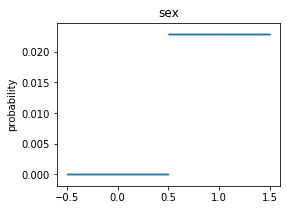

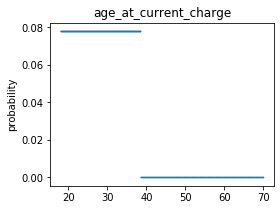

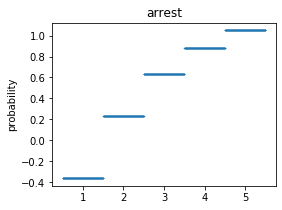

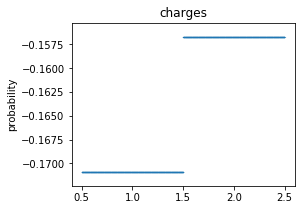

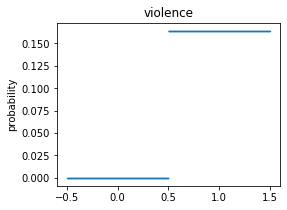

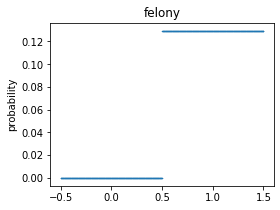

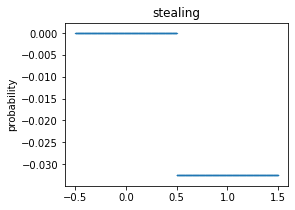

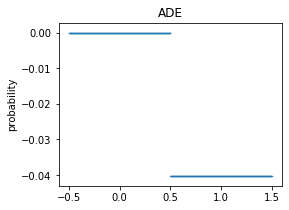

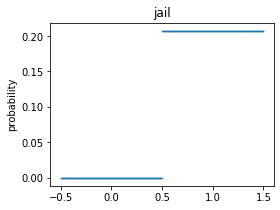

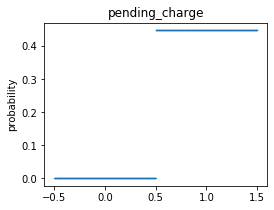

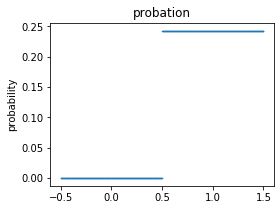

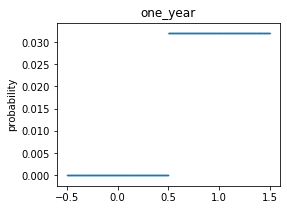

In [5]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'], indicator="KY")

## RiskSLIM

In [6]:
## load stumps data
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

## drop features
train_data = train_data.drop(['person_id', 'screening_date', 'race'], axis=1)
test_data = test_data.drop(['person_id', 'screening_date', 'race'], axis=1)

## split x & y
train_x, train_y = train_data.loc[:,:'current_violence>=1'], train_data['recid_two_year'].values
test_x, test_y = test_data.loc[:,:'current_violence>=1'], test_data['recid_two_year'].values
cols = train_x.columns

In [7]:
## train on best param chosen by Lasso Stumps from above
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.009, random_state=816).fit(train_x, train_y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

33

In [9]:
sub_X = train_data[selected_features]
sub_X.insert(0, '(Intercept)', 1)
cols = sub_X.columns.tolist()
sub_X = sub_X.values
sub_Y = train_y.copy().reshape(-1,1)
sample_weights = np.repeat(1, len(sub_Y))

## create new data dictionary
new_train_data = {
    'X': sub_X,
    'Y': sub_Y,
    'variable_names': cols,
    'outcome_name': "ky_general2",
    'sample_weights': sample_weights
}

In [10]:
model_info, mip_info, lcpa_info = slim.risk_slim(new_train_data, 
                                                 max_coefficient=10, 
                                                 max_L0_value=5, 
                                                 c0_value=1e-6, 
                                                 max_runtime=200)
slim.print_model(model_info['solution'], new_train_data)

setting c0 = 0.0 to ensure that intercept is not penalized
10/02/19 @ 04:05 PM | 761 rows in lookup table
10/02/19 @ 04:05 PM | ------------------------------------------------------------
10/02/19 @ 04:05 PM | runnning initialization procedure
10/02/19 @ 04:05 PM | ------------------------------------------------------------
10/02/19 @ 04:05 PM | CPA produced 2 cuts
10/02/19 @ 04:05 PM | running naive rounding on 12 solutions
10/02/19 @ 04:05 PM | best objective value: 0.5915
10/02/19 @ 04:05 PM | rounding produced 5 integer solutions
10/02/19 @ 04:05 PM | best objective value is 0.6047
10/02/19 @ 04:05 PM | running sequential rounding on 12 solutions
10/02/19 @ 04:05 PM | best objective value: 0.5915
10/02/19 @ 04:05 PM | sequential rounding produced 2 integer solutions
10/02/19 @ 04:05 PM | best objective value: 0.6047
10/02/19 @ 04:05 PM | polishing 7 solutions
10/02/19 @ 04:05 PM | best objective value: 0.6047
10/02/19 @ 04:05 PM | polishing produced 5 integer solutions
10/02/19 @

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/02/19 @ 04:05 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.6000.
Tried aggregator 1 time.
Reduced MIP has 35 rows, 70 columns, and 135 nonzeros.
Reduced MIP has 33 binaries, 35 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.08 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

 117395 38528        0.5784    18        0.5945        0.5751   617599    3.26%           rho_4 D 117395 117394     29
Elapsed time = 25.77 sec. (41259.76 ticks, tree = 13.16 MB, solutions = 6)
 119535 39186        0.5761    22        0.5945        0.5751   630950    3.26%          rho_21 D 119535 119534     26
 121575 39816        0.5751    10        0.5945        0.5751   644314    3.26%          rho_17 U 121575 121574     31
 123752 40996        0.5860    15        0.5945        0.5751   659559    3.26%           rho_2 D 123752 123751     30
 125588 41499        0.5782    15        0.5945        0.5751   672738    3.26%          rho_17 D 125588 125586     22
 127483 41877        0.5908     1        0.5945        0.5751   684538    3.26%          rho_17 U 127483 127481     26
 129700 42716        0.5813    19        0.5945        0.5751   697801    3.26%           rho_5 D 129700 129699     28
 131599 43369        0.5751    14        0.5945        0.5751   711578    3.26%           rh

 301425 96592        0.5751    22        0.5940        0.5751  1992139    3.18%          rho_17 U 301425 301412     26
 308198 98431        0.5751    23        0.5940        0.5751  2040045    3.18%          rho_13 D 308198 290198     24
 315670 100982        0.5869    15        0.5940        0.5752  2084124    3.16%          rho_15 D 315670 315668     55
 323740 104197        cutoff              0.5940        0.5753  2129985    3.15%          rho_23 U 323740 323738     55
 331550 106759        0.5909    12        0.5940        0.5754  2176158    3.14%          rho_22 N 331550 331548     34
 339295 109344        cutoff              0.5940        0.5754  2218535    3.13%           rho_6 U 339295 339294     45
 347135 111698        cutoff              0.5940        0.5755  2263215    3.12%           rho_6 U 347135 347134     36
 355103 114184        0.5857    18        0.5940        0.5755  2305715    3.11%          rho_14 D 355103 355101     52
Elapsed time = 95.67 sec. (168137.42 ticks

In [83]:
slim.print_model(model_info['solution'], new_train_data)

+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-7 + score))   |                  |           |
| ============================================ | ================ | ========= |
| p_arrest>=1                                  |         5 points |   + ..... |
| age_at_current_charge<=47                    |         1 points |   + ..... |
| p_arrest>=2                                  |         1 points |   + ..... |
| p_arrest>=4                                  |         1 points |   + ..... |
| p_arrest>=7                                  |         1 points |   + ..... |
| ============================================ | ================ | ========= |
| ADD POINTS FROM ROWS 1 to 5                  |            SCORE |   = ..... |
+----------------------------------------------+------------------+-----------+


## Corel

In [99]:
## load stumps data
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

## drop features
train_data = train_data.drop(['person_id', 'screening_date', 'race'], axis=1)
test_data = test_data.drop(['person_id', 'screening_date', 'race'], axis=1)

## split x & y
train_x, train_y = train_data.loc[:,:'current_violence>=1'], train_data['recid_two_year'].values
test_x, test_y = test_data.loc[:,:'current_violence>=1'], test_data['recid_two_year'].values

train_y[train_y == -1]=0
test_y[test_y == -1]=0

cols = train_x.columns.tolist()

In [101]:
COREL = corels.CorelsClassifier(n_iter=10000, 
                                verbosity=[],
                                c=1e-4).fit(train_x, train_y, features=cols)

In [102]:
print(COREL.rl_)

RULELIST:
if [age_at_current_charge<=61 && p_arrest>=3]:
  prediction = True
else 
  prediction = False
